*Necessary imports and setups*

In [1]:
#!pip install pandas seaborn matplotlib ipywidgets numpy statsmodels numpy

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from numpy import arange
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt
import ipywidgets as widgets
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import math
from numpy import diff
import warnings

%matplotlib inline

*Preparing dataset of target sales*

In [4]:
df_sales_target = pd.read_csv('Sales Target.csv', low_memory=False)

df_sales_target.columns = list(map(lambda x: x[9:],df_sales_target.columns))
#df_sales_target.columns

df_sales_target['month'] = list(map(lambda x: x.split(' ')[1],df_sales_target['Target_Order_20_Date']))
df_sales_target['year'] = list(map(lambda x: x.split(' ')[2],df_sales_target['Target_Order_20_Date']))
df_sales_target['datemask'] = pd.to_datetime(df_sales_target['year'].astype(str)  + df_sales_target['month'], format='%Y%B')

df_sales_target.loc[:,'Target_Sales_20_Target'] = list(map(lambda x: int(x.replace(',','')),df_sales_target.loc[:,'Target_Sales_20_Target']))

df_sales_target = df_sales_target.groupby(['Target_Category','Target_Segment', 'month', 'year','datemask'], group_keys=False).sum().reset_index()

df_sales_target.columns = ['Category','Segment','month','year','datemask','sales_target']

df_sale_target = df_sales_target.sort_values(by=['datemask','Category','Segment'], ascending=True)

/var/folders/lf/s97_46wj3fj7npt_h0dbnnrh0000gn/T/ipykernel_44599/4265418173.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_sales_target.loc[:,'Target_Sales_20_Target'] = list(map(lambda x: int(x.replace(',','')),df_sales_target.loc[:,'Target_Sales_20_Target']))
/var/folders/lf/s97_46wj3fj7npt_h0dbnnrh0000gn/T/ipykernel_44599/4265418173.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sales_target = df_sales_target.groupby(['Target_Category','Target_Segment', 'month', 'year','datemask'], group_keys=False).sum().reset_index()


*Preparing dataset of actual sales*

In [5]:
df_sales_actual = pd.read_csv('Sample - Orders.csv', low_memory=False)

df_sales_actual.columns = list(map(lambda x: x[18:],df_sales_actual.columns))
#df_sales_actual.columns

df_sales_actual['month'] = list(map(lambda x: x.split(' ')[1],df_sales_actual['Orders_Order_20_Date']))
df_sales_actual['year'] = list(map(lambda x: x.split(' ')[2],df_sales_actual['Orders_Order_20_Date']))
df_sales_actual['datemask'] = pd.to_datetime(df_sales_actual['year'].astype(str)  + df_sales_actual['month'], format='%Y%B')

df_sales_actual.loc[:,'Orders_Sales_2c__24_'] = list(map(lambda x: int(x.replace(',','')),df_sales_actual.loc[:,'Orders_Sales_2c__24_']))

df_sales_actual = df_sales_actual.groupby(['Orders_Category','Orders_Segment', 'month', 'year','datemask'], group_keys=False).sum().reset_index()[['Orders_Category','Orders_Segment','month','year','datemask','Orders_Sales_2c__24_']]

df_sales_actual.columns = ['Category','Segment','month','year','datemask','sales_actual']

df_sales_actual = df_sales_actual.sort_values(by=['datemask','Category','Segment'], ascending=True)

/var/folders/lf/s97_46wj3fj7npt_h0dbnnrh0000gn/T/ipykernel_44599/308041144.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_sales_actual.loc[:,'Orders_Sales_2c__24_'] = list(map(lambda x: int(x.replace(',','')),df_sales_actual.loc[:,'Orders_Sales_2c__24_']))
/var/folders/lf/s97_46wj3fj7npt_h0dbnnrh0000gn/T/ipykernel_44599/308041144.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sales_actual = df_sales_actual.groupby(['Orders_Category','Orders_Segment', 'month', 'year','datemask'], group_keys=False).sum().reset_index()[['Orders_Category','Orders_Segment','mont

*Merging two available datasets*

In [6]:
df_final = pd.merge(df_sales_actual, df_sales_target, on=['Category','Segment','month','year','datemask'], how='inner')
df_final['sales_diff'] = round((df_final['sales_actual'] - df_final['sales_target']) / df_final['sales_target'] * 100,2)

*Creating a dynamic dashboard of the actual sales vs target*

In [7]:
@widgets.interact


def create_diff_plot(Year = pd.unique(df_final['year']),
                     Segment = pd.unique(df_final['Segment']),
                     Category = pd.unique(df_final['Category']),
                     MergeSegment = False):
    
    sns.set_style("ticks",{'axes.grid' : True})
    figure, axis = plt.subplots(2,1)
    figure.set_figheight(12)
    figure.set_figwidth(20)
    if MergeSegment:
        data_prep1 = df_final[(df_final['year'] == Year) & (df_final['Category'] == Category)]
        data_prep1 = data_prep1.groupby(['month','datemask'],group_keys=False).sum().reset_index().sort_values(by=['datemask'], ascending=True)
        data_prep1.loc[:,'sales_diff'] = round((data_prep1['sales_actual'] - data_prep1['sales_target']) / data_prep1['sales_target'] * 100,2)
        graph1 = sns.barplot(data = data_prep1, x = 'month', y ='sales_diff', ax=axis[0])
        axis[0].set_title(f'Monthly deviations from target, {Category}, {Year}')
    else:
        data_prep1 = df_final[(df_final['year'] == Year) & (df_final['Segment'] == Segment)]
        graph1 = sns.barplot(data = data_prep1, x = 'month', y ='sales_diff', hue = 'Category', ax=axis[0])
        axis[0].legend(loc=2, prop={'size': 13})
        axis[0].set_title(f'Monthly deviations from target, {Segment}, {Year}')
    
    graph1.axhline(0, color = 'grey', linewidth=0.5)
    xcoords = list(arange(0.5,12,1))
    for xc in xcoords:
        graph1.axvline(x=xc, color='grey', linewidth=0.5)
    graph1.set(ylabel='Sales Difference, % of target', xlabel='Month')
    graph1.set_yticks(list(arange(-15,55,5)))
    for i in graph1.containers:
        graph1.bar_label(i,)


    data_prep2 = df_final[(df_final['year'] == Year) & (df_final['Segment'] == Segment) & (df_final['Category'] == Category)]
    axis[1].plot(data_prep2['month'], data_prep2['sales_actual'], 'green', label = 'Actual Sales')
    axis[1].plot(data_prep2['month'], data_prep2['sales_target'], 'b--', label = 'Target Sales')
    axis[1].legend(loc=2, prop={'size': 13})
    axis[1].set(ylabel='Sales Volume, $', xlabel='Month')
    axis[1].set_title(f'Target and actual sales dinamics, {Category}, {Segment} segment, {Year}')
    for x, y, z in zip(data_prep2['month'], data_prep2['sales_target'], data_prep2['sales_target']-data_prep2['sales_actual']):
        plt.text(x = list(data_prep2['month']).index(x)+0.1 if z<0 else x,
                 y = y+600 if z>0 else y-500,
                 s = z)
    fig_out = plt.gcf()
    plt.show()
    fig_out.savefig('dash.jpg')

interactive(children=(Dropdown(description='Year', options=('2019', '2020', '2021', '2022'), value='2019'), Dr…

*A little bit of prediction with time series analysis (difference of logarithms is used to increase the chance of stationarity in data by omitting stochastic trends)*

/var/folders/lf/s97_46wj3fj7npt_h0dbnnrh0000gn/T/ipykernel_44599/1764662721.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_prediction = df_final.groupby(['datemask']).sum().reset_index()[['datemask','sales_actual','sales_target']]


<Figure size 640x400 with 0 Axes>

Text(0.5, 1.0, 'Actual vs predicted sales for 2022')

Text(0.5, 0, 'date')

Text(0, 0.5, 'Log change in sales')

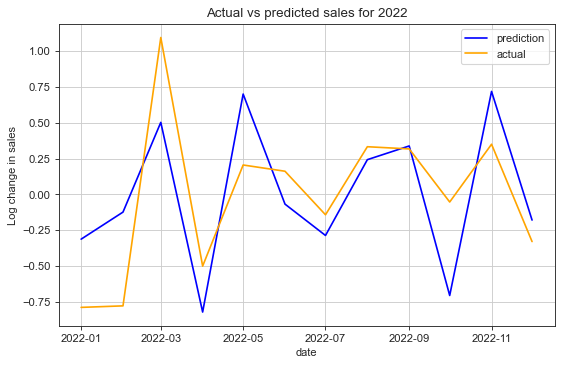

In [8]:
df_prediction = df_final.groupby(['datemask']).sum().reset_index()[['datemask','sales_actual','sales_target']]
df_prediction.loc[:,'sales_act_log'] = list(map(lambda x: math.log(x), list(df_prediction.loc[:,'sales_actual'])))
df_prediction.loc[:,'sales_act_log_ts'] = [0]+list(diff(df_prediction.loc[:,'sales_act_log']))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    arima_model = ARIMA(df_prediction['sales_act_log_ts'][:36], order=(3,1,6))
    model = arima_model.fit()
    predictions = model.forecast(steps=12)


    plt.figure(figsize=(8, 5), dpi=80)
    plt.plot(df_prediction['datemask'][36:], predictions, color='blue', label = 'prediction')
    plt.plot(df_prediction['datemask'][36:], df_prediction['sales_act_log_ts'][36:], color='orange', label='actual')
    plt.title('Actual vs predicted sales for 2022')
    plt.xlabel('date')
    plt.ylabel('Log change in sales')
    plt.legend()
    plt.savefig('Forecast.jpg')
    plt.show()
